In [38]:
!pip install numpy==1.26.4


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, TensorDataset
import os

# delete the ones that are in use
from torchvision.models import VGG16_Weights, MobileNet_V2_Weights, ResNet18_Weights, resnet18, mobilenet_v2, vgg16
from PIL import Image, ImageFile
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Cuda available, training on GPU")
else:
    print("Cuda unavailable, training on CPU")

Cuda available, training on GPU


In [41]:
# --------------------------------------------------- #
#                    Softcode section
# --------------------------------------------------- #

data_dir = '/home/bartek/Documents/msc-newdataset/'
data_ratio = (.75, .2, .05)         # train, validate, test
epochs = 50

# trained pytorch model to save path
model_name = 'msc-ResNet18.pth'
history_data_name = 'msc-ResNet18History.csv'
resources_path = f'/home/bartek/PycharmProjects/msc-TestModel/ResNet18-Resources'

In [42]:
# --------------------------------------------------- #
#                   Print the classes
# --------------------------------------------------- #

class_names = []

for class_name in os.listdir(data_dir):
    class_names.append(class_name)

print(f"Classes being trained: {class_names}")

Classes being trained: ['parfum', 'matches', 'bottle', 'pen', 'mug']


In [43]:
# --------------------------------------------------- #
#           Transform the data before
#        putting into the Neural Network
# --------------------------------------------------- #

transform_train = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),      # 3 channels - RGB
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [44]:
# --------------------------------------------------- #
#              Creating datasets
# --------------------------------------------------- #

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
print(f"Full dataset: {len(full_dataset)} images")

# Data partitioning
all_indices = list(range(len(full_dataset)))

train_size = data_ratio[0]
val_size = data_ratio[1] / (data_ratio[1] + data_ratio[2])

train_idx, rest_idx = train_test_split(
    all_indices, train_size=train_size, shuffle=True, random_state=42
)

val_idx, test_idx = train_test_split(
    rest_idx, train_size=val_size, shuffle=False, random_state=42   # shuffle not required
)

# Creating subsets
train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)
test_data = Subset(full_dataset, test_idx)

# Info
print(f"Train_data length: {len(train_data)}")
print(f"Val_data length:   {len(val_data)}")
print(f"Test_data length:  {len(test_data)}")

Full dataset: 979 images
Train_data length: 734
Val_data length:   196
Test_data length:  49


In [45]:
# conversion of tensor to image
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5)) + np.array((0.5))
    image = image.clip(0, 1)
    return image

In [46]:
# setting batch size for dataloaders and workers
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [47]:
# Initializing model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Use appropriate weights
model = model.to(device)

# Freezing previous layers
for param in model.parameters():
    param.requires_grad = False

# Changing the last layer to classify 5 objects
n_inputs = model.fc.in_features  # This should work for ResNet
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout for better generalization
    nn.Linear(n_inputs, len(class_names))  # Change output classes to 5
)
model = model.to(device)  # Moving to GPU

# Check model architecture
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
# Cost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0005)

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Model training loop

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    val_running_loss = 0.0
    val_running_corrects = 0

    model.train()
    for inputs, labels in train_loader:  # with train loader
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        running_loss += loss.item() * inputs.size(0)

    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:  # with val loader
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data).item()
            val_running_loss += val_loss.item() * val_inputs.size(0)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects / len(train_data)

    val_epoch_loss = val_running_loss / len(val_data)
    val_epoch_acc = val_running_corrects / len(val_data)

    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print(f'Epoch {e+1}: Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_acc:.4f}')
    print(f'Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.4f}')


Epoch 1: Training loss: 1.8776, Training accuracy: 0.1921
Validation loss: 1.6473, Validation accuracy: 0.1990
Epoch 2: Training loss: 1.8017, Training accuracy: 0.2343
Validation loss: 1.5959, Validation accuracy: 0.3316
Epoch 3: Training loss: 1.7175, Training accuracy: 0.2480
Validation loss: 1.5364, Validation accuracy: 0.3061
Epoch 4: Training loss: 1.7453, Training accuracy: 0.2534
Validation loss: 1.4613, Validation accuracy: 0.4184
Epoch 5: Training loss: 1.6228, Training accuracy: 0.2684
Validation loss: 1.4418, Validation accuracy: 0.3878
Epoch 6: Training loss: 1.6186, Training accuracy: 0.2984
Validation loss: 1.3826, Validation accuracy: 0.4694
Epoch 7: Training loss: 1.5434, Training accuracy: 0.3338
Validation loss: 1.3475, Validation accuracy: 0.4643
Epoch 8: Training loss: 1.5415, Training accuracy: 0.3365
Validation loss: 1.3351, Validation accuracy: 0.4745
Epoch 9: Training loss: 1.4726, Training accuracy: 0.3597
Validation loss: 1.3041, Validation accuracy: 0.5459
E

In [49]:
# model evaluation

model.eval()
test_loss = 0.0
test_corrects = 0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = model(test_inputs)
        test_loss_value = criterion(test_outputs, test_labels)

        _, test_preds = torch.max(test_outputs, 1)
        test_corrects += torch.sum(test_preds == test_labels.data).item()
        test_loss += test_loss_value.item() * test_inputs.size(0)

test_epoch_loss = test_loss / len(test_data)
test_epoch_acc = test_corrects / len(test_data)

print(f'Test loss: {test_epoch_loss:.4f}, Test accuracy: {test_epoch_acc:.4f}')

Test loss: 0.9108, Test accuracy: 0.7143


In [50]:
# saving pytorch model

model_save_path = os.path.join(resources_path, model_name)

torch.save(model.state_dict(), model_save_path)
print(f"Pytorch model saved to: {model_save_path}")

Pytorch model saved to: /home/bartek/PycharmProjects/msc-TestModel/ResNet18-Resources/msc-ResNet18.pth


In [51]:
# saving training data to csv

history_data_save_path = os.path.join(resources_path, history_data_name)

# creating dictionary with data
history_dict = {
    'epoch': range(1, epochs + 1),
    'train_loss': running_loss_history,
    'train_accuracy': running_corrects_history,
    'val_loss': val_running_loss_history,
    'val_accuracy': val_running_corrects_history
}

# creating DataFrame with created dictionary
history_df = pd.DataFrame(history_dict)

# save to csv
history_df.to_csv(history_data_save_path, index=False)

In [1]:
# Data visualize
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()
plt.savefig(f'{resources_path}/ResNet18_running_loss.png')

NameError: name 'plt' is not defined

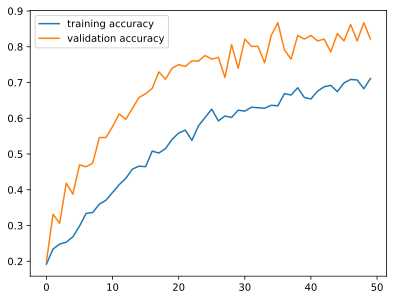

In [53]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()
plt.savefig(f'{resources_path}/ResNet18_running_corrects.png')

In [54]:
print(f'Training accuracy: {epoch_acc:.4f}')
print(f'Validation accuracy: {val_epoch_acc:.4f}')

Training accuracy: 0.7112
Validation accuracy: 0.8214
